# DELE CA1 PART B: RECURRENT NEURAL NETWORK 
## Name: Rajarethinam Abarna 
## Class: DAAA/FT/2B/22 
## Admin No: p2415857 

# Importing Modules

In [52]:
# Core libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from deep_translator import GoogleTranslator

# Model development
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, Bidirectional,
    GlobalMaxPooling1D, BatchNormalization
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Data utilities
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Evaluation metrics
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)

## Loading the dataset

In [2]:
df = pd.read_csv('Movie reviews.csv')

# Data exploration

- `df.head()` displays the first few rows to get a quick look at the review content and score values.
- `df.columns` helps identify all column names, including any that may need to be removed or cleaned.
- `df.shape` shows the total number of rows and columns in the dataset.

- The dataset contains 527 rows and 4 columns.
- One column (`'Are there ways for you to generate more data? Splitting up sentences, would that help?'`) contains only NaN values and is likely an artifact from import or a misformatted header. This column will be dropped during preprocessing.
- Reviews are in different languages, confirming the need for language translation during data cleaning.

In [3]:
print(df.head())        # Preview first few rows
print(df.columns)       # Check column names
print(df.shape)         # See number of rows and columns

                                              Review  Score  \
0  Filem ini hebat! Aksi yang mendebarkan dan plo...    0.1   
1  Filem ini hebat! Aksi yang mendebarkan dan plo...    0.9   
2  Filem ini hebat! Aksi yang mendebarkan dan plo...    0.5   
3  Sayang sekali, pelakon tidak memberikan persem...    0.8   
4  Jalan cerita yang kompleks dan penuh emosi. Su...    0.2   

   Are there ways for you to generate more data? Spliting up sentences, would that help?  \
0                                                NaN                                       
1                                                NaN                                       
2                                                NaN                                       
3                                                NaN                                       
4                                                NaN                                       

  Language  
0    Malay  
1    Malay  
2    Malay  
3    Malay  
4  

To further inspect the dataset, I used `df.info()` to view the column data types, non-null counts, and memory usage. The dataset contains 527 entries across 4 columns.

- The `'Review'` and `'Language'` columns are complete with 527 non-null entries.
- The `'Score'` column has 2 missing values.
- The column `'Are there ways for you to generate more data? Splitting up sentences, would that help?'` has 0 non-null values, meaning it's entirely empty and should be dropped.
  
The missing values were confirmed using `df.isnull().sum()`, which provides a clear count of missing entries per column. These insights will guide the next steps in cleaning, particularly removing the empty column and handling the two missing scores.

In [4]:
# Basic structure
print(df.info())

# Missing values per column
print("\nMissing values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 4 columns):
 #   Column                                                                                 Non-Null Count  Dtype  
---  ------                                                                                 --------------  -----  
 0   Review                                                                                 527 non-null    object 
 1   Score                                                                                  525 non-null    float64
 2   Are there ways for you to generate more data? Spliting up sentences, would that help?  0 non-null      float64
 3   Language                                                                               527 non-null    object 
dtypes: float64(2), object(2)
memory usage: 16.6+ KB
None

Missing values:
Review                                                                                     0
Score                           

### Language Distribution

The bar chart below visualizes the distribution of languages present in the dataset. As shown, the majority of reviews are written in English (298), followed by Malay (226). There are also a very small number of reviews in Chinese (2) and Nippon (1).

Given that non-English reviews make up a substantial portion of the data—particularly Malay—I decided to translate all non-English reviews into English. This approach minimizes data loss and ensures consistent language input for the model, allowing it to learn from the entire dataset rather than excluding valuable non-English samples.


In [5]:
print("\nLanguages in dataset:")
print(df['Language'].value_counts())


Languages in dataset:
Language
English    298
Malay      226
Chinese      2
Nippon       1
Name: count, dtype: int64


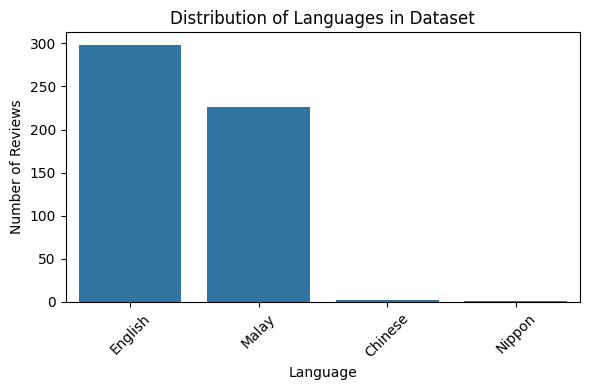

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Language', order=df['Language'].value_counts().index)
plt.title('Distribution of Languages in Dataset')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Score Distribution Analysis

The histogram above shows the distribution of review scores in the dataset. It is clear that the dataset is highly imbalanced, with a large concentration of scores clustered between 0.0 and 0.2. This suggests that the majority of reviews are labeled with very low sentiment scores. In contrast, there are relatively few reviews with high scores (above 0.6), leading to an uneven class distribution.

This imbalance may bias the model toward predicting lower sentiment classes more frequently. To address this, techniques such as class weighting or data augmentation may be required to improve model performance on underrepresented classes.


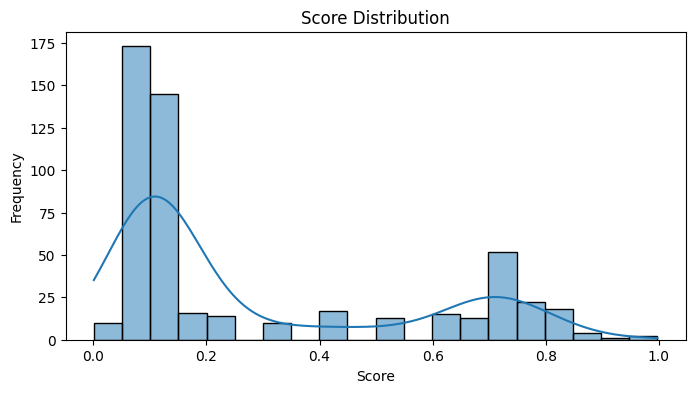

In [7]:
plt.figure(figsize=(8,4))
sns.histplot(df['Score'], bins=20, kde=True)
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Data Preprocessing

## Data cleaning

### Dropping unnecessary column
The third column was dropped because it was unnecessary for the sentiment analysis task. It did not contribute meaningfully to the review content or sentiment label, so removing it helps simplify the dataset and avoid irrelevant features during model training.

In [8]:
df.drop(df.columns[2], axis=1, inplace=True)
print(df.head())

                                              Review  Score Language
0  Filem ini hebat! Aksi yang mendebarkan dan plo...    0.1    Malay
1  Filem ini hebat! Aksi yang mendebarkan dan plo...    0.9    Malay
2  Filem ini hebat! Aksi yang mendebarkan dan plo...    0.5    Malay
3  Sayang sekali, pelakon tidak memberikan persem...    0.8    Malay
4  Jalan cerita yang kompleks dan penuh emosi. Su...    0.2    Malay


### Dropping duplicate rows
To reduce redundancy and ensure that each review contributes only once to the model's learning, I began by identifying duplicate entries in the `'Review'` column. A total of 122 duplicate reviews were found using `df.duplicated()`.

I then removed these duplicates using `df.drop_duplicates()` while keeping the first occurrence of each review. After that, I applied a `groupby()` operation on the `'Review'` column and computed the mean score for any remaining duplicate texts. This ensures that if the same review appears with different sentiment scores, its final score reflects the average sentiment, reducing bias and noise in the training data.

In [9]:
# Count duplicate reviews
num_duplicates = df.duplicated(subset='Review').sum()
print(f"Number of duplicate reviews: {num_duplicates}")

Number of duplicate reviews: 122


In [10]:
df = df.drop_duplicates()

In [11]:
df = df.groupby('Review', as_index=False).agg({'Score': 'mean'})
print(df.head())

                                              Review  Score
0  A big surprise in the middle of the film! Thri...   0.12
1  A big surprise in the plot! Thrilling action t...   0.10
2  A cinematic experience that is unforgettable. ...   0.10
3  A cinematic marvel! The visuals are breathtaki...   0.08
4  A complex yet engaging plot. A major surprise ...   0.06


### Translating languages
To ensure consistency in the input data and allow the use of English-based language models, each review was translated into English. A try-except block was included to prevent the program from crashing if a translation fails, ensuring robustness in preprocessing.

In [12]:
def translate_to_english(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except Exception as e:
        return text  # fallback in case of error

df['Review'] = df['Review'].apply(lambda x: translate_to_english(str(x)))
print(df.head())

                                              Review  Score
0  A big surprise in the middle of the film! Thri...   0.12
1  A big surprise in the plot! Thrilling action t...   0.10
2  A cinematic experience that is unforgettable. ...   0.10
3  A cinematic marvel! The visuals are breathtaki...   0.08
4  A complex yet engaging plot. A major surprise ...   0.06


### Lowercasing Text for Consistency
Converting all review text to lowercase ensures uniformity in the data. This prevents the model from treating the same word differently due to capitalization (e.g., "Good" vs "good"), which reduces vocabulary size and improves model generalization and consistency during training.

In [13]:
df['Review'] = df['Review'].str.lower()
print(df.head())

                                              Review  Score
0  a big surprise in the middle of the film! thri...   0.12
1  a big surprise in the plot! thrilling action t...   0.10
2  a cinematic experience that is unforgettable. ...   0.10
3  a cinematic marvel! the visuals are breathtaki...   0.08
4  a complex yet engaging plot. a major surprise ...   0.06


### Removing punctuation

In this step, all punctuation marks, numbers, and special characters were removed from the review text using a regular expression — with one important exception: full stops (`.`) were preserved. This cleaning approach ensures that the text remains free of noisy characters that don't contribute meaningful value to sentiment analysis, such as symbols or digits.

However, full stops were intentionally kept in the text to retain sentence boundaries. This is important because the reviews will later be split into individual sentences for sentence-level analysis or augmentation.

In [14]:
def clean_text(text):
    # Keep only letters, spaces, and fullstops
    text = re.sub(r'[^a-zA-Z\s\.]', '', text)
    return text

df['Review'] = df['Review'].apply(clean_text)
print(df.head())

                                              Review  Score
0  a big surprise in the middle of the film thril...   0.12
1  a big surprise in the plot thrilling action th...   0.10
2  a cinematic experience that is unforgettable. ...   0.10
3  a cinematic marvel the visuals are breathtakin...   0.08
4  a complex yet engaging plot. a major surprise ...   0.06


### Removing Common Words to Focus on Sentiment
Stopwords are common words like "the", "is", "and", and "in" that frequently appear in text but typically do not carry significant meaning, especially in sentiment analysis. Removing these words helps reduce noise in the data and allows the model to focus on the most informative and sentiment-relevant terms, improving its ability to distinguish between positive and negative reviews.

In [15]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df['Review'] = df['Review'].apply(remove_stopwords)
print(df.head())

                                              Review  Score
0          big surprise middle film thrilling action   0.12
1     big surprise plot thrilling action throughout.   0.10
2   cinematic experience unforgettable. im impressed   0.10
3  cinematic marvel visuals breathtaking narrativ...   0.08
4  complex yet engaging plot. major surprise awai...   0.06


### Lemmatization

I used a simple lemmatization method by treating all words as verbs. This reduces common word forms (like "running" or "played") to their base form ("run", "play") without adding complexity. It keeps the preprocessing fast and effective, helping to reduce vocabulary size and improve consistency without needing full POS tagging.

In [16]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in text.split()])

df['Review'] = df['Review'].apply(lemmatize_text)
print(df.head())

                                              Review  Score
0             big surprise middle film thrill action   0.12
1        big surprise plot thrill action throughout.   0.10
2     cinematic experience unforgettable. im impress   0.10
3  cinematic marvel visuals breathtaking narrativ...   0.08
4  complex yet engage plot. major surprise await end   0.06


## Feature engineering

### Choosing Binary Classification 

Initially, I considered multiple approaches for handling the sentiment scores, which range from 0 to 1. Regression was ruled out early because it attempts to predict an exact score — which is difficult to interpret in a sentiment context and highly sensitive to small variations in input. Since review sentiment is better represented categorically (e.g., good vs bad), regression is not a good fit for this task.

I then explored a multi-class classification approach by dividing the score into five sentiment categories (Very Bad, Bad, Neutral, Good, Very Good). However, the model consistently struggled to accurately identify the minority classes. This was likely due to class imbalance, where certain labels had significantly fewer examples than others, causing the model to favor majority classes during training. Even after applying class weighting, performance remained inconsistent.

Given these limitations, I opted for a binary classification approach — distinguishing between "good" and "bad" sentiment. This simplifies the learning task and aligns well with the skewed distribution in the dataset. Interestingly, in this dataset, **lower scores actually indicate more positive sentiment**, while higher scores correspond to more negative reviews.

To address this, I used a simple function to convert the continuous score into binary labels:  
- Scores ≤ 0.5 are labeled as `0` (positive/good)  
- Scores > 0.5 are labeled as `1` (negative/bad)

In [17]:
def score_to_label(score):
    if score <= 0.5:
        return 0  # good
    else:
        return 1  # bad

df['Label'] = df['Score'].apply(score_to_label)
print(df['Label'].value_counts())
print(df.head())

Label
0    308
1     97
Name: count, dtype: int64
                                              Review  Score  Label
0             big surprise middle film thrill action   0.12      0
1        big surprise plot thrill action throughout.   0.10      0
2     cinematic experience unforgettable. im impress   0.10      0
3  cinematic marvel visuals breathtaking narrativ...   0.08      0
4  complex yet engage plot. major surprise await end   0.06      0


###  Train-Validation-Test Split

At this stage, I split the dataset into training, validation, and test sets. This is done before any sentence splitting or tokenization to ensure the model evaluation remains fair and unbiased. By isolating `X_train` early, I can later expand it sentence-by-sentence without affecting the validation or test data.

Additionally, splitting now allows me to fit the tokenizer and any future preprocessing pipeline **only on the training data**, which is a best practice in machine learning. This prevents information from the validation or test sets from leaking into the model during training.


In [18]:
# Define features and labels
X = df['Review']           # Features (text)
y = df['Label'].astype(int)  # Target (0 or 1)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

# Confirm shapes
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (283,), Validation: (61,), Test: (61,)


###  Expanding Training Data by Splitting Sentences

To increase the volume and granularity of training data, I split each review in `X_train` into individual sentences using full stops. This helps the model learn from shorter, more focused text segments rather than relying solely on full-length reviews, which may contain mixed or diluted sentiment.

Each sentence inherits the original review’s sentiment label, ensuring consistency while providing the model with a wider variety of training examples. This approach is especially beneficial in deep learning, where more data can lead to better generalization. It also aligns with earlier preprocessing, where full stops were preserved specifically to support this step.


In [19]:
# Initialize lists to hold expanded data
expanded_X_train = []
expanded_y_train = []

# Loop through each review and its label in training data
for review, label in zip(X_train, y_train):
    # Split the review into sentences using full stops
    sentences = [s.strip() for s in review.split('.') if s.strip()]
    
    # Add each sentence and repeat the label
    expanded_X_train.extend(sentences)
    expanded_y_train.extend([label] * len(sentences))

# Confirm results
print(f"Original training samples: {len(X_train)}")
print(f"Expanded training samples: {len(expanded_X_train)}")

Original training samples: 283
Expanded training samples: 505


### Tokenization and Padding Pipeline

After expanding the training data by splitting reviews into individual sentences, I used a custom `TextPreprocessingPipeline` to tokenize and pad the text. This pipeline performs three key steps:

1. **Tokenizer Fitting:** The tokenizer is fit only on the sentence-level `X_train` data (`expanded_X_train`), ensuring that the model vocabulary is learned exclusively from training samples and preventing data leakage.

2. **Text to Sequence Conversion:** Each sentence or review is converted into a sequence of integers based on the tokenizer's word index.

3. **Padding:** All sequences are padded or truncated to a fixed length (`max_len=500`) to ensure uniform input shape for the model. Padding is done at the end (`post`) to preserve sentence beginnings.

Validation and test sets are transformed using the same tokenizer, but not split into sentences, preserving their structure for fair evaluation. This approach increases the amount of training data, improves learning from shorter contexts, and ensures consistency across all datasets.

In [26]:
# Custom preprocessing pipeline
class TextPreprocessingPipeline:
    def __init__(self, num_words=5000, max_len=500, oov_token="<OOV>"):
        self.tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
        self.max_len = max_len

    def fit(self, texts):
        """Learn vocabulary from training data."""
        self.tokenizer.fit_on_texts(texts)

    def transform(self, texts):
        """Convert texts to padded sequences."""
        sequences = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post')

    def fit_transform(self, texts):
        """Fit tokenizer and return padded sequences."""
        self.fit(texts)
        return self.transform(texts)

# Initialize the pipeline
pipeline = TextPreprocessingPipeline(num_words=5000, max_len=500)

# Fit and transform training data (sentence-split)
X_train_pad = pipeline.fit_transform(expanded_X_train)

# Transform validation and test sets (not sentence-split)
X_val_pad = pipeline.transform(X_val)
X_test_pad = pipeline.transform(X_test)
expanded_y_train = np.array(expanded_y_train)

### Addressing Class Imbalance with Class Weights

To handle the imbalance between positive and negative sentiment labels, I used `compute_class_weight()` from `sklearn` to calculate weights inversely proportional to class frequencies. This helps the model give more attention to the minority class during training.

The `balanced` mode ensures that the weight assigned to each class is:
\[
\text{weight} = \frac{\text{total samples}}{\text{number of classes} \times \text{samples in class}}
\]

The result is a dictionary of weights:
- Class `0` (majority): lower weight
- Class `1` (minority): higher weight

These weights are passed to the model during training using the `class_weight` parameter in `model.fit()`, helping to reduce bias toward the more frequent class.


In [23]:
# addressing imbalance
# Compute weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['Label']),
    y=df['Label']
)

# Convert to dictionary
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.6574675324675324, 1: 2.0876288659793816}


# Building Model & Model Improvement 

During experimentation, I initially tested **simpler models** consisting of just an Embedding layer followed by a single LSTM or Dense layer. These lightweight models trained quickly but achieved only around **70% accuracy**, likely due to their limited ability to capture complex patterns in sentence structure and semantics.

I also tried **deeper models** with stacked LSTM layers and multiple Dense layers. While these more complex architectures showed some improvement, they tended to plateau around **80% accuracy**. This was likely due to overfitting or vanishing gradients in deeper LSTM layers, especially with limited or imbalanced data.

The selected model architecture was the best-performing configuration, achieving the **highest test accuracy (>90%)**.

* **Embedding Layer (128 dims):** Converts input tokens into dense vector representations. A larger embedding dimension allows richer semantic learning.
* **Bidirectional LSTM (64 units):** Processes text in both directions, capturing context from past and future words.
* **GlobalMaxPooling1D:** Compresses LSTM outputs into a fixed-size vector by capturing the most important feature from each sequence. Reduces complexity and helps prevent overfitting.
* **Dense Layer (64, ReLU):** Adds non-linear transformation capacity to capture deeper patterns from the pooled sequence.
* **Dropout (0.4):** Regularizes the model by randomly disabling neurons during training to reduce overfitting.
* **Output Layer (Sigmoid):** Outputs a probability between 0 and 1 for binary classification (Good/Bad sentiment).

This configuration balances model expressiveness and generalization, making it highly effective for sentence-level binary sentiment analysis.

To improve model training and prevent overfitting, the following callbacks were used:

ModelCheckpoint: Automatically saves the model's best weights based on validation accuracy, ensuring the best-performing version is preserved.

ReduceLROnPlateau: Monitors validation accuracy and reduces the learning rate when it stops improving, helping the model converge better and avoid getting stuck in local minima.

In [43]:
model = Sequential()

# Embedding layer with more expressive word vectors
model.add(Embedding(input_dim=5000, output_dim=128, input_length=500))

# Bidirectional LSTM with return_sequences=True to allow pooling
model.add(Bidirectional(LSTM(64, return_sequences=True)))

# Global max pooling to reduce dimensionality and capture key features
model.add(GlobalMaxPooling1D())

# Dense layer for non-linear transformation
model.add(Dense(64, activation='relu'))

# Dropout to prevent overfitting
model.add(Dropout(0.4))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))


checkpoint = ModelCheckpoint(
    filepath='RNN_best_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, min_lr=1e-5, verbose=1)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 500, 128)          640000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 500, 128)         98816     
 nal)                                                            
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                

# Training Model

The model was trained using padded sequences generated from sentence-split training data (`X_train_pad`) and their corresponding binary labels (`expanded_y_train`). A validation set (`X_val_pad`, `y_val`) was used to monitor the model's generalization performance during training. I trained the model for 40 epochs with a batch size of 64 to balance learning speed and gradient stability. To address class imbalance, I applied `class_weight`, which penalizes the model more for misclassifying underrepresented classes. Two callbacks were included: `ModelCheckpoint` to save the model’s best weights based on validation accuracy, and `ReduceLROnPlateau` to dynamically reduce the learning rate if validation accuracy plateaued, improving convergence. This setup ensures that training remains robust, well-regularized, and tuned for optimal performance.


In [44]:
# Train the model using sentence-split and padded data
history = model.fit(
    X_train_pad,
    expanded_y_train,
    validation_data=(X_val_pad, y_val),
    epochs=40,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/40
8/8 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.3386
Epoch 1: val_accuracy improved from -inf to 0.75410, saving model to RNN_best_weights.h5
8/8 [==============================] - 11s 598ms/step - loss: 0.6933 - accuracy: 0.3386 - val_loss: 0.6836 - val_accuracy: 0.7541 - lr: 0.0010
Epoch 2/40
8/8 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.6475
Epoch 2: val_accuracy improved from 0.75410 to 0.80328, saving model to RNN_best_weights.h5
8/8 [==============================] - 3s 391ms/step - loss: 0.6851 - accuracy: 0.6475 - val_loss: 0.6734 - val_accuracy: 0.8033 - lr: 0.0010
Epoch 3/40
8/8 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.7861
Epoch 3: val_accuracy improved from 0.80328 to 0.85246, saving model to RNN_best_weights.h5
8/8 [==============================] - 3s 397ms/step - loss: 0.6663 - accuracy: 0.7861 - val_loss: 0.6352 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 4/40
8/8 [========

#  Evaluating on test data

After training, the best-performing model weights (saved automatically by the `ModelCheckpoint` callback based on highest validation accuracy) were loaded using `model.load_weights('RNN_best_weights.h5')`. This ensures that the evaluation is done using the most optimal version of the model, rather than the final training state. The model was then evaluated on the test set to assess its performance on unseen data. This final test accuracy provides an unbiased measure of how well the model is expected to generalize in real-world scenarios. In this case, the model achieved a strong test accuracy of 91.80%.

In [46]:
# Load the best saved model
model.load_weights('RNN_best_weights.h5')

# Evaluate the best model on the test set
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

2/2 [==============================] - 0s 119ms/step - loss: 0.1674 - accuracy: 0.9180
Test Accuracy: 91.80%


# Visualising results

###  Training and Validation Performance Analysis

The accuracy and loss curves demonstrate that the model has learned effectively and generalizes well to unseen data. As shown in the left plot, training accuracy steadily increases and quickly converges near 100%, while validation accuracy stabilizes just below it, around 93%, indicating strong generalization without overfitting. The right plot shows a consistent downward trend in both training and validation loss, with occasional minor fluctuations. Importantly, the final test accuracy and loss (shown as red dashed lines) align closely with the validation curves, confirming that the model performs reliably on new data. This is especially meaningful in this context, where the data is imbalanced and sentence-level, yet the model maintains performance across all sets, justifying the architectural choices and regularization applied.


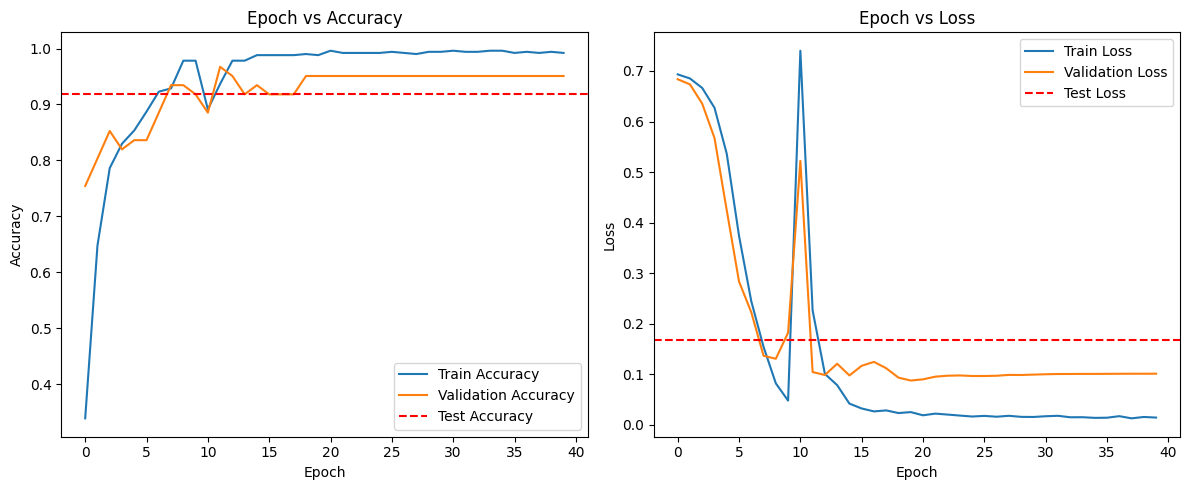

In [45]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=loss, color='r', linestyle='--', label='Test Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

###  Confusion Matrix Analysis

The confusion matrix provides a clear breakdown of how well the model distinguishes between the two sentiment classes: Good (0) and Bad (1). The model correctly classified 43 out of 46 "Good" reviews and 13 out of 15 "Bad" reviews, indicating strong performance on both classes. Only 5 total misclassifications occurred, suggesting that the model generalizes well without favoring the majority class excessively. This balance is especially important given the dataset's class imbalance, and confirms the effectiveness of using class weights and sentence-level training to enhance prediction quality.

2/2 [==============================] - 2s 89ms/step


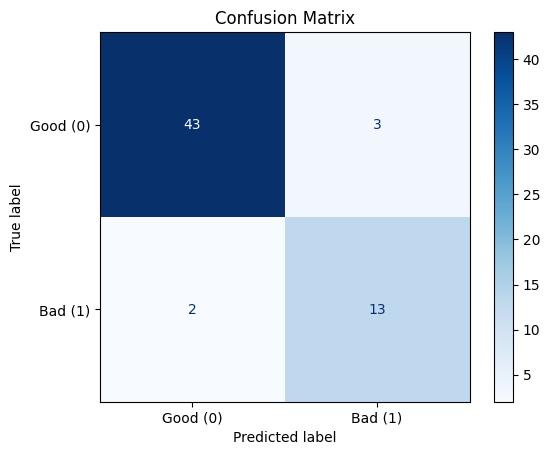

In [47]:
# Get predictions from the model
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # convert to 0/1

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good (0)", "Bad (1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

###  Classification Report Summary

The classification report provides detailed insights into the model’s performance across both sentiment classes. For the "Good" class, the model achieved a high precision of 0.96 and an F1-score of 0.95, showing that it accurately identifies positive reviews while minimizing false positives. The "Bad" class, despite having fewer examples, was still classified effectively with a precision of 0.81 and a recall of 0.87. This balance across classes is reflected in the macro average F1-score of 0.89 and an overall accuracy of 92%. These results confirm that the model performs reliably on both majority and minority classes, thanks to sentence-level augmentation and the use of class weighting during training.

In [48]:
print(classification_report(y_test, y_pred, target_names=["Good", "Bad"]))

              precision    recall  f1-score   support

        Good       0.96      0.93      0.95        46
         Bad       0.81      0.87      0.84        15

    accuracy                           0.92        61
   macro avg       0.88      0.90      0.89        61
weighted avg       0.92      0.92      0.92        61



### ROC Curve and AUC Analysis

The Receiver Operating Characteristic (ROC) curve visualizes the trade-off between the true positive rate (sensitivity) and the false positive rate for different classification thresholds. In this case, the ROC curve shows a strong upward curve toward the top-left corner, indicating excellent model performance. The Area Under the Curve (AUC) is **0.98**, which reflects a very high level of separability between the "Good" and "Bad" classes. This means the model is highly capable of distinguishing between the two classes, even under different threshold settings, making it a reliable and well-calibrated binary classifier.


2/2 [==============================] - 0s 181ms/step


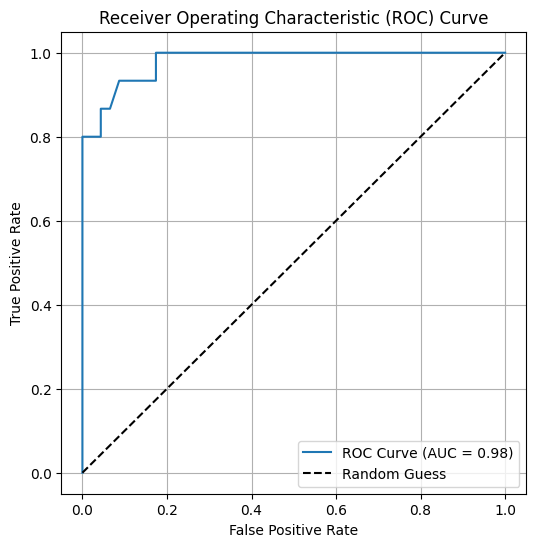

In [51]:
# Get predicted probabilities for the positive class
y_pred_probs = model.predict(X_test_pad).flatten()  # Shape (n_samples,)

# Compute False Positive Rate, True Positive Rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()